# set path

In [210]:
import os
try:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=False)

    #unpack zipped file (reading files from drive is slow)
    os.chdir('/content')
    import shutil
    shutil.unpack_archive("/content/drive/My Drive/ai-side-projects/self-supervised-halos/data/freya_postprocess.zip", "./")
    rootpath = '/content/freya_postprocess/'

except:
    %matplotlib inline
    rootpath = '/Users/sdbykov/work/self-supervised-halos/data/freya_postprocess/'


# Imports

In [211]:
import torch

In [212]:
import torchvision

In [213]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm
import time

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torch.utils.data import TensorDataset, DataLoader



try:
    subhalos_df = pd.read_pickle('/content/drive/My Drive/ai-side-projects/self-supervised-halos/data/subhalos_df.pkl')
except:
    subhalos_df = pd.read_pickle('/Users/sdbykov/work/self-supervised-halos/data/subhalos_df.pkl')
subhalos_df['logSubhaloMass'] = np.log10(subhalos_df['SubhaloMass']*1e10/0.6774)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device=='cuda':
    print(torch.cuda.get_device_properties(0).name)



cpu


# Data loaders and transformers

In [217]:
mass_bins = np.linspace(11, 14.7, 11) ## number of classes = len(mass_bins) - 1 = 10
mass_bins_nums = np.histogram(subhalos_df['logSubhaloMass'], bins=mass_bins)[0]
mass_bins_weights = np.max(mass_bins_nums)/mass_bins_nums
mass_bins_weights = mass_bins_weights / np.sum(mass_bins_weights)
mass_bins_weights = torch.tensor(mass_bins_weights, dtype=torch.float32)

class HaloDataset(torch.utils.data.Dataset):
    mass_bins = np.linspace(11, 14.7, 11)  # Define mass_bins globally or pass as argument

    def __init__(self, root_dir, subhalos_df):
        self.root_dir = root_dir
        self.subhalos_df = subhalos_df
        self.files = glob(root_dir + '*.npz')
        self.halos_ids = [int(x.split('_')[-1].split('.')[0]) for x in self.files]
        self.loaded_data = self.preload_data()

    def preload_data(self):
        #lesson learned: loading all data at once is faster than loading it on the fly. Before that all files were loaded for each index separately and with the inference time of 0.1 sec the data loading was 30 sec
        data_dict = {}
        for file in self.files:
            halo_id = int(file.split('_')[-1].split('.')[0])
            data = np.load(file)
            data_dict[halo_id] = {
                'map_2d_xy': data['map_2d_xy'],
                'map_2d_xz': data['map_2d_xz'],
                'map_2d_yz': data['map_2d_yz'],
            }
        return data_dict

    def __len__(self):
        return len(self.halos_ids)

    def select_random_projection(self):
        return np.random.choice(['xy', 'xz', 'yz'])

    def __getitem__(self, idx):
        halo_id = self.halos_ids[idx]
        data = self.loaded_data[halo_id]

        # Select a random projection
        selected_projection = self.select_random_projection()

        if selected_projection == 'xy':
            selected_data = np.expand_dims(data['map_2d_xy'], axis=0)
        elif selected_projection == 'xz':
            selected_data = np.expand_dims(data['map_2d_xz'], axis=0)
        elif selected_projection == 'yz':
            selected_data = np.expand_dims(data['map_2d_yz'], axis=0)


        label_mass = self.subhalos_df.loc[halo_id]['logSubhaloMass']
        label_class = np.digitize(label_mass, self.mass_bins) - 1
        label = (label_mass, label_class)

        return selected_data, label

#dataset = HaloDataset(root_dir = rootpath, subhalos_df=subhalos_df)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [235]:
def test_transformation(dataloader, transform = None, plot = True):
    t = time.time()
    for i, (data, label) in enumerate(dataloader):
        projection = data
        if transform:
            transformed_data = transform(projection)
        else:
            transformed_data = projection

        transformed_data = transformed_data.to(device)

        if plot and i<2:
            fig, ax = plt.subplots(2, 2, figsize=(5, 5))
            ax = ax.flatten()
            ax[0].imshow(projection[0][0], cmap='afmhot')
            ax[1].imshow(transformed_data[0][0], cmap='afmhot')
            ax[2].imshow(projection[-1][0], cmap='afmhot')
            ax[3].imshow(transformed_data[-1][0], cmap='afmhot')
            plt.title(f"batch {i}, first and last samples")
            plt.show()
    
    print('Transform Time:', time.time()-t, 'transform applied:', transform is not None)
    return projection, transformed_data


class RandomRotationWithMinFill:
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, img):
        # Ensure the input is a tensor
        if not isinstance(img, torch.Tensor):
            raise TypeError("Input should be a tensor")

        # Get the minimum value of the original image
        min_val = img.min()
        #min_val = 0

        # Rotate the image
        angle = torch.empty(1).uniform_(-self.degrees, self.degrees).item()

        #stack min_vals and angles for printing
        #print(min_val, angle)

        rotated_img = torchvision.transforms.functional.rotate(img, angle=angle, fill = min_val)
    

        # Create a mask where the rotated image is zero
        mask = rotated_img == 0

        # Fill the masked area with the minimum value of the original image
        rotated_img[mask] = min_val

        return rotated_img

class FillInfWithMin:
    def __init__(self, fill_value=-np.inf):
        self.fill_value = fill_value

    def __call__(self, batch):
        # Create a mask to identify non-inf values
        mask = batch != self.fill_value

        # Compute the minimum value per image, ignoring -inf values
        min_per_image = torch.where(mask, batch, torch.inf).view(batch.size(0), -1).min(dim=1)[0]

        # Reshape min_per_image to match the dimensions of batch
        min_per_image = min_per_image.view(batch.size(0), 1, 1, 1)

        # Replace -inf values with the corresponding minimum values
        filled_batch = torch.where(batch == self.fill_value, min_per_image, batch)

        return filled_batch


default_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.7, 0.99)),
    transforms.RandomRotation(degrees=180, fill = -np.inf),
])

my_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.7, 0.99)),
    RandomRotationWithMinFill(degrees=180),
])


new_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.7, 0.99)),
    transforms.RandomRotation(degrees=180, fill=-np.inf),
    FillInfWithMin(fill_value=-np.inf)  # Custom transform to fill -inf with min per image
])

new_transform_accelerated = transforms.Compose([
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.7, 0.99)),
    transforms.RandomRotation(degrees=180, fill=-np.inf),
    FillInfWithMin_accelerated(fill_value=-np.inf)  # Custom transform to fill -inf with min per image
])


In [237]:
orig, _ = test_transformation(dataloader, None, plot = False)
test_transformation(dataloader, default_transform, plot=False)
test_transformation(dataloader, my_transform, plot=False)
test_transformation(dataloader, new_transform, plot=False);
test_transformation(dataloader, new_transform_accelerated, plot=False);



Transform Time: 2.652839183807373 transform applied: False
Transform Time: 3.1693520545959473 transform applied: True
Transform Time: 3.900629997253418 transform applied: True
Transform Time: 3.674708843231201 transform applied: True
Transform Time: 3.4647960662841797 transform applied: True


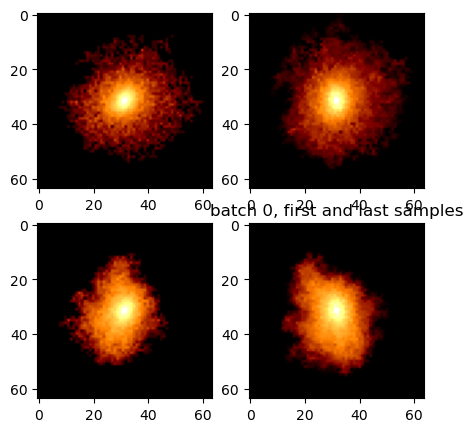

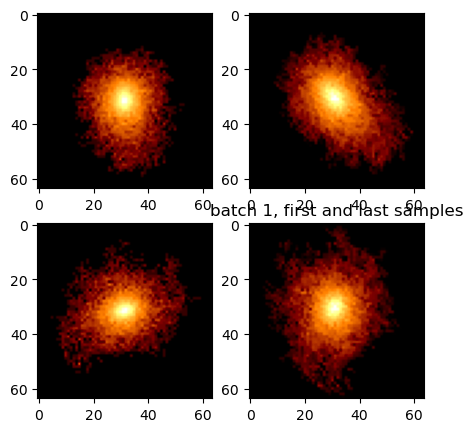

Transform Time: 4.485527753829956 transform applied: True


In [234]:
test_transformation(dataloader, new_transform, plot=True);


In [216]:
class CustomTransform:
    def __init__(self, degrees=180, fill_value=-np.inf):
        self.random_resized_crop = transforms.RandomResizedCrop(size=(224, 224))  # Example size
        self.random_rotation = transforms.RandomRotation(degrees=degrees, fill=fill_value)
        self.fill_value = fill_value

    def __call__(self, batch):
        # Apply RandomResizedCrop and RandomRotation
        batch = self.random_resized_crop(batch)
        batch = self.random_rotation(batch)

        # Create a mask to identify non-inf values
        mask = batch != self.fill_value

        # Compute the minimum value per image, ignoring -inf values
        min_per_image = torch.where(mask, batch, torch.inf).min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]

        # Replace -inf values with the corresponding minimum values
        filled_batch = torch.where(batch == self.fill_value, min_per_image, batch)

        return filled_batch

custom_transform = CustomTransform(degrees=180, fill_value=-np.inf)


In [205]:
orig, _ = test_transformation(dataloader, None, plot=False)
transformed_batch = custom_transform(orig)


Transform Time: 3.0866012573242188 None


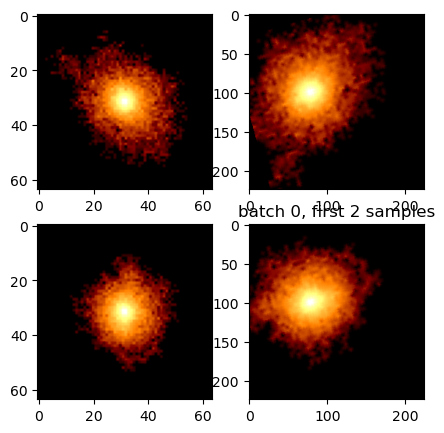

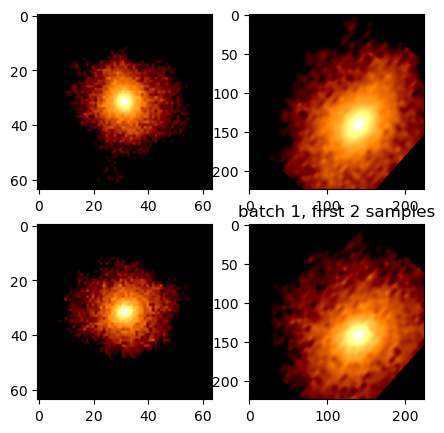

Transform Time: 13.316228866577148 <__main__.CustomTransform object at 0x7feb279f7f70>


(tensor([[[[-3.5124, -3.5124, -3.5124,  ..., -3.5124, -3.5124, -3.5124],
           [-3.5124, -3.5124, -3.5124,  ..., -3.5124, -3.5124, -3.5124],
           [-3.5124, -3.5124, -3.5124,  ..., -3.5124, -3.5124, -3.5124],
           ...,
           [-3.5124, -3.5124, -3.5124,  ..., -3.5124, -3.5124, -3.5124],
           [-3.5124, -3.5124, -3.5124,  ..., -3.5124, -3.5124, -3.5124],
           [-3.5124, -3.5124, -3.5124,  ..., -3.5124, -3.5124, -3.5124]]],
 
 
         [[[-3.0941, -3.0941, -3.0941,  ..., -3.0941, -3.0941, -3.0941],
           [-3.0941, -3.0941, -3.0941,  ..., -3.0941, -3.0941, -3.0941],
           [-3.0941, -3.0941, -3.0941,  ..., -3.0941, -3.0941, -3.0941],
           ...,
           [-3.0941, -3.0941, -3.0941,  ..., -3.0941, -3.0941, -3.0941],
           [-3.0941, -3.0941, -3.0941,  ..., -3.0941, -3.0941, -3.0941],
           [-3.0941, -3.0941, -3.0941,  ..., -3.0941, -3.0941, -3.0941]]],
 
 
         [[[-3.1326, -3.1326, -3.1326,  ..., -3.1326, -3.1326, -3.1326],
       

In [208]:
test_transformation(dataloader, custom_transform, plot=True)

In [206]:
transformed_batch

tensor([[[[-3.5673, -3.5673, -3.5673,  ..., -3.5673, -3.5673, -3.5673],
          [-3.5673, -3.5673, -3.5673,  ..., -3.5673, -3.5673, -3.5673],
          [-3.5673, -3.5673, -3.5673,  ..., -3.5673, -3.5673, -3.5673],
          ...,
          [-3.5673, -3.5673, -3.5673,  ..., -3.5673, -3.5673, -3.5673],
          [-3.5673, -3.5673, -3.5673,  ..., -3.5673, -3.5673, -3.5673],
          [-3.5673, -3.5673, -3.5673,  ..., -3.5673, -3.5673, -3.5673]]],


        [[[-3.4299, -3.4299, -3.4299,  ..., -3.4299, -3.4299, -3.4299],
          [-3.4299, -3.4299, -3.4299,  ..., -3.4299, -3.4299, -3.4299],
          [-3.4299, -3.4299, -3.4299,  ..., -3.4299, -3.4299, -3.4299],
          ...,
          [-3.4299, -3.4299, -3.4299,  ..., -3.4299, -3.4299, -3.4299],
          [-3.4299, -3.4299, -3.4299,  ..., -3.4299, -3.4299, -3.4299],
          [-3.4299, -3.4299, -3.4299,  ..., -3.4299, -3.4299, -3.4299]]],


        [[[-3.3768, -3.3768, -3.3768,  ..., -3.3768, -3.3768, -3.3768],
          [-3.3768, -3.376

In [171]:
# test_transformation(dataloader, None)
# test_transformation(dataloader, contrast_transforms)
# test_transformation(dataloader, contrast_transforms_default)


In [ ]:
def time_data_loading(dataloader, model = None, transform = None):
    t = time.time()
    n = len(dataloader)
    for i, (batch_data_full, batch_label) in enumerate(dataloader):
        projections = batch_data_full[1]

        if transform is not None:
            input_img = transform(projections)
        else:
            input_img = projections[0]
        
        input_img = input_img.to(device)

        label = batch_label[1].to(device)

        if model is not None:
            model(input_img)

    print(f'{n} batches loaded in {time.time() - t:.2f} sec. {batch_size=}; inference={model is not None}; transform={transform is not None}')



# Initialize dataset and dataloader

if device=='cpu':
    batch_size = 128
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
else:
    print('dataloader on gpu')
    batch_size = 2048
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers = 2)

time_data_loading(dataloader)
time_data_loading(dataloader, transform=select_views_and_transform)

In [ ]:
batch_data_full, batch_label = next(iter(dataloader))
batch_data = batch_data_full[1]

view1 = select_views_and_transform(batch_data)
orig = batch_data[0]

fig, axs = plt.subplots(8, 2, figsize=(4, 18))

for i in range(8):
    axs[i, 0].imshow(orig[i][0].cpu().numpy(), cmap='afmhot')
    axs[i, 1].imshow(view1[i][0].cpu().numpy(), cmap='afmhot')
    #axs[i, 2].imshow(view2[i][0].cpu().numpy(), cmap='afmhot')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    #axs[i, 2].axis('off')

# Classification model for mass bin

## Model

In [ ]:
class ClassificationNN(nn.Module):

    "Encoder network"
    def __init__(self):
        super(ClassificationNN, self).__init__()

        image_channels = 1
        self.cnn = nn.Sequential(
            nn.Conv2d(image_channels, 8, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(8, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            #nn.Linear(64, 64),
            #nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        logits =  self.cnn(x)
        #make always class 0 for debugging, 9.1 on the first element and 0.1 on the rest
        #logits = torch.zeros_like(logits)+0.1
        #logits[:, 0] = 9.0
        return logits

def classification_train_step(
        epoch,
        model,
        criterion,
        optimizer,
        scheduler,
        dataloader,
        dataloader_val,
        history=None,
        device='cpu',
        ):

    model.train()

    running_loss = 0.0

    for i, (batch_data_full, batch_label) in enumerate(dataloader):
        batch_size = batch_label[0].shape[0]

        batch_data = batch_data_full[1]
        batch_label = batch_label[1].to(device)


        view1 = select_views_and_transform(batch_data)
        view1 = view1.to(device)

        pred_class = model(view1)
        loss = criterion(pred_class, batch_label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step() if scheduler is not None else None

        running_loss += loss.item()

    running_loss /= len(dataloader)
    #print(f'Epoch {epoch}, loss: {running_loss}')

    if history is not None:
        history['loss'].append(running_loss)

    if dataloader_val is not None:
        model.eval()
        running_loss_val = 0.0
        for i, (batch_data_full, batch_label) in enumerate(dataloader_val):
            batch_size = batch_label[0].shape[0]

            batch_data = batch_data_full[1]
            batch_label = batch_label[1].to(device)

            view1 = select_views_and_transform(batch_data)
            view1 = view1.to(device)

            pred_class = model(view1)
            loss = criterion(pred_class, batch_label)

            running_loss_val += loss.item()

        running_loss_val /= len(dataloader_val)
        #print(f'Epoch {epoch}, val loss: {running_loss_val}')
    else:
        running_loss_val = None

    if history is not None:
        history['val_loss'].append(running_loss_val)

    return running_loss, running_loss_val


def classification_train(epochs,
                 model,
                 criterion,
                 optimizer,
                 scheduler,
                 dataloader,
                 dataloader_val,
                 history=None,
                 device = 'cpu'):

    pbar = tqdm(range(epochs))

    history = {'loss': [], 'val_loss': []} if history is None else history

    try:
        for epoch in pbar:
            loss, loss_val = classification_train_step(
                epoch,
                model,
                criterion,
                optimizer,
                scheduler,
                dataloader,
                dataloader_val,
                history=history,
                device=device
            )
            pbar.set_postfix({'loss': loss, 'val_loss': loss_val})

    except KeyboardInterrupt:
        print('Interrupted')

    return history

In [ ]:
print(f'Batch size: {batch_size}')

f_train = 0.5
train_size = int(f_train*len(dataset))
val_size = len(dataset) - train_size

#random split with the same distribution of classes
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
#val_loader = None


lr = 5e-3

classification_model = ClassificationNN().to(device)

criterion = nn.CrossEntropyLoss(weight=mass_bins_weights.to(device)).to(device)
optimizer = torch.optim.Adam(classification_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


In [ ]:
# #debug shapes
# batch_data_full, batch_label = next(iter(dataloader))
# batch_data = batch_data_full[1]

# output = classification_model(batch_data[0].to(device))

# #print(f'Output shape: {output}')
# print(f'Output shape: {output.shape}')


# time_data_loading(dataloader)
# time_data_loading(dataloader, classification_model)
# time_data_loading(dataloader, classification_model, select_views_and_transform)

## Training

In [ ]:
n_epochs = 1

history = classification_train(n_epochs,
                       classification_model,
                       criterion,
                       optimizer,
                       scheduler=scheduler,
                        dataloader=dataloader,
                        dataloader_val=val_loader,
                        device=device)
                    


In [ ]:
print(history)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

---

In [ ]:
import cProfile, pstats
pr = cProfile.Profile()
pr.enable()

n_epochs = 1

history = classification_train(n_epochs,
                       classification_model,
                       criterion,
                       optimizer,
                       scheduler=scheduler,
                        dataloader=dataloader,
                        dataloader_val=val_loader,
                        device=device)




pr.disable()
pr.create_stats()
s = pstats.Stats(pr)
#s.sort_stats('time')
s.sort_stats('cumtime')
s.print_stats()

In [ ]:
s = pstats.Stats(pr)
s.sort_stats('cumtime')
s.print_stats()